In [1]:
import torch
from math import pi

def Euler(f, t_span, y0, u, params, t_eval=None, eps=0.001,):
#     y0 = torch.tensor(y0, dtype=torch.float, requires_grad=True)
#     params = torch.tensor(params, dtype=torch.float, requires_grad=True)
    t0 = torch.tensor([t_span[0]], dtype=torch.float, requires_grad=True)
    T = torch.tensor([t_span[1]], dtype=torch.float, requires_grad=True)
    
    if t_eval is not None:
        t_eval = torch.tensor(t_eval, dtype=torch.float, requires_grad=True) 
        
        if (t_eval < min(t0, T)).any() or (t_eval > max(t0, T)).any():
            raise ValueError("Values in `t_eval` are not within `t_span`.")          
    else: 
        t_eval = torch.linspace(t_span[0], t_span[1], int((t_span[1] - t_span[0]) / eps + 1))
        
    t_size = torch.numel(t_eval)
    y = torch.tensor((), dtype=torch.float, requires_grad=True)
    y = y.new_empty((t_size, torch.numel(y0)))
    y[0, :] = y0
    for i in range(1, t_size):
        y[i, :] = y0 + f(t_eval[i - 1], y0, u, params) * eps
        y0 = y[i, :]
        
    return t_eval, y

In [2]:
def integration(f, y, t_eval, u, params, eps=0.1,):
    result = eps * ((f(y, u(params, t_eval[0]), 0) + f(y, u(params, t_eval[-1]), -1)) / 2 + 
                     sum(f(y, u(params, t_eval[i]), i) for i in range(1, torch.numel(t_eval) - 1)))
    return result

In [3]:
def gradient_descent(solver, f, y0, t_span, u, params, quality_control, 
                     t_eval_euler=None, step=0.1, eps=0.001,):
    MAX_ITER = 100
    k = 0
    y0 = torch.tensor(y0, dtype=torch.float, requires_grad=True)
    params = torch.tensor(params, dtype=torch.float, requires_grad=True)
    fun, _, _ = solver(f, t_span, y0, u, params, quality_control, t_eval_euler, eps)
    fun.backward()
    grad = params.grad
    grad = grad / grad.norm()

    while params.grad.norm() > eps and k <= MAX_ITER:
        p = params - step * grad
        p = p.clone().detach().requires_grad_(True)
        k += 1
        print(k)
        
        fun, y, t = solver(f, t_span, y0, u, p, quality_control, t_eval_euler, eps)
        _fun = solver(f, t_span, y0, u, params, quality_control, t_eval_euler, eps)[0]
        if (fun - _fun) < 0:
            params.grad.data.zero_()
            fun.backward()
            grad = p.grad
            grad = grad / grad.norm()
            params = p
            print('result:', params)
            print('grad:', grad)
            print('error y1:', y[-1, 0] - pi)
            print('error y2:', y[-1, 1])
        else:
            step = step / 10
    
    return params, fun, y, t

In [4]:
def solver(y, t_span, y0, u, params, quality_control, t_eval_euler=None, eps=0.001,):
    t_eval, y_eval = Euler(y, t_span, y0, u, params, t_eval_euler, eps)
    I = integration(quality_control, y_eval, t_eval, u, params, eps)
    return I + 1e4 * (y_eval[-1, 0] - pi) ** 2 + 1e4 * (y_eval[-1, 1] - 0) ** 2, y_eval, t_eval

In [5]:
def spacecraft_orientation(t, y, u, params,):
    dy1dt = y[1]
    dy2dt = u(params, t)
    equation_system = torch.FloatTensor([dy1dt, dy2dt])
    return equation_system

def quality_control_4(y, u, t,):
    return u ** 2

def u_4(params, t,):
    return - params[0] * pi * t + params[1] * pi
# OPTIMAL = 6 * pi - 12 * pi * t

y0 = [0., 0.]
params = [15., 3.]

par, f, y, t = gradient_descent(solver, spacecraft_orientation, y0, [0, 1], u_4, 
                                params, quality_control_4, step=0.1, eps=0.001)
par
# t_eval, y_eval = Euler(spacecraft_orientation, [0, 1], y0, u_4, params)
# y_eval

1
result: tensor([14.9386,  3.0789], requires_grad=True)
grad: tensor([ 0.6168, -0.7871])
error y1: tensor(-6.1084, grad_fn=<SubBackward0>)
error y2: tensor(-13.7693, grad_fn=<SelectBackward>)
2
result: tensor([14.8769,  3.1576], requires_grad=True)
grad: tensor([ 0.6197, -0.7848])
error y1: tensor(-5.9527, grad_fn=<SubBackward0>)
error y2: tensor(-13.4252, grad_fn=<SelectBackward>)
3
result: tensor([14.8150,  3.2361], requires_grad=True)
grad: tensor([ 0.6228, -0.7824])
error y1: tensor(-5.7972, grad_fn=<SubBackward0>)
error y2: tensor(-13.0814, grad_fn=<SelectBackward>)
4
result: tensor([14.7527,  3.3144], requires_grad=True)
grad: tensor([ 0.6260, -0.7799])
error y1: tensor(-5.6419, grad_fn=<SubBackward0>)
error y2: tensor(-12.7379, grad_fn=<SelectBackward>)
5
result: tensor([14.6901,  3.3924], requires_grad=True)
grad: tensor([ 0.6293, -0.7772])
error y1: tensor(-5.4869, grad_fn=<SubBackward0>)
error y2: tensor(-12.3946, grad_fn=<SelectBackward>)
6
result: tensor([14.6272,  3.4701]

tensor([11.5017,  5.7752], requires_grad=True)

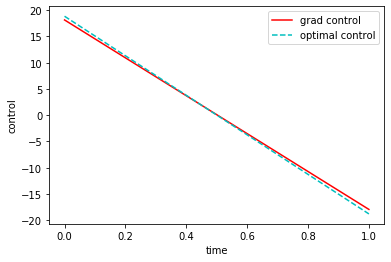

In [6]:
import matplotlib.pyplot as plt

U = [u_4(par, i) for i in t]
_U = [6 * pi - 12 * pi * i for i in t]
traj_x2 = [6 * pi * i - 6 * pi * i ** 2 for i in t]
traj_x1 = [-2 * pi * i ** 3 + 3 * pi * i ** 2 for i in t]

plt.plot(t.detach().numpy(), U, 'r', label='grad control')
plt.plot(t.detach().numpy(), _U, 'c--', label='optimal control')
plt.legend()
plt.xlabel('time')
plt.ylabel('control')
plt.savefig('opt', dpi=400)

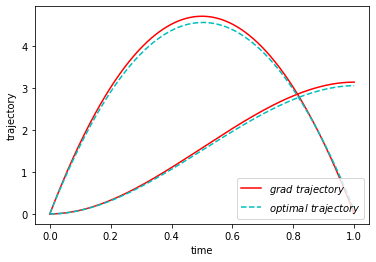

In [7]:
plt.plot(t.detach().numpy(), traj_x2, 'r-', label=r'$grad\ trajectory$')
plt.plot(t.detach().numpy(), traj_x1, 'r-')
plt.plot(t.detach().numpy(), y[:, 0].detach().numpy(), 'c--', label=r'$optimal\ trajectory$')
plt.plot(t.detach().numpy(), y[:, 1].detach().numpy(), 'c--')
plt.legend()
plt.xlabel('time')
plt.ylabel('trajectory')
plt.savefig('traj', dpi=400)